In [16]:
import os
import sys
import json
from osgeo import gdal, osr

In [ ]:
def get_raster_info(file_path):
    # Open the dataset—GDAL will automatically use any ancillary files.
    ds = gdal.Open(file_path)
    if ds is None:
        print(f"Failed to open {file_path}")
        return

    # Retrieve the projection WKT string.
    projection_wkt = ds.GetProjectionRef()
    print("Projection (WKT):\n", projection_wkt)

    # Retrieve the geotransform (origin, pixel size, rotation, etc.).
    geotransform = ds.GetGeoTransform()
    print("GeoTransform:", geotransform)
    
    # Create a SpatialReference object from the WKT.
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection_wkt)

    # Retrieve the EPSG code—this assumes that the authority is set.
    # The GetAttrValue("AUTHORITY", 1) call returns the EPSG code if available.
    epsg_code = srs.GetAttrValue("AUTHORITY", 1)
    print("EPSG Code:", epsg_code)

    # Print a couple of identifiable names.
    geogcs_name = srs.GetAttrValue("GEOGCS")
    projcs_name = srs.GetAttrValue("PROJCS")
    print("Geographic Coordinate System:", geogcs_name)
    if projcs_name:
        print("Projected Coordinate System:", projcs_name)
    
    ds = None

# Example usage:
# Replace 'your_file.tif' with your raster file path.
get_raster_info('Transformed/MODIS_Gross_Primary_Production_GPP/2018_GP_norm.tif')


Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (15.112499998642782, 0.0083333333, 0.0, -10.574027896121724, 0.0, -0.0083333333)
EPSG Code: 4326
Geographic Coordinate System: WGS 84


In [ ]:
def get_EPSG(file_path):
    # Open the dataset—GDAL will automatically use any ancillary files.
    ds = gdal.Open(file_path)
    if ds is None:
        print(f"Failed to open {file_path}")
        return

    # Retrieve the projection WKT string.
    projection_wkt = ds.GetProjectionRef()
    print("Projection (WKT):\n", projection_wkt)

    # Retrieve the geotransform (origin, pixel size, rotation, etc.).
    geotransform = ds.GetGeoTransform()
    print("GeoTransform:", geotransform)
    
    # Create a SpatialReference object from the WKT.
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection_wkt)

    # Retrieve the EPSG code—this assumes that the authority is set.
    # The GetAttrValue("AUTHORITY", 1) call returns the EPSG code if available.
    epsg_code = srs.GetAttrValue("AUTHORITY", 1)
    ds = None
    return epsg_code 


In [51]:
import shutil

def gather_raster_files(root_dir):
    """
    Recursively collects primary raster files.
    We consider files ending in .tif, .tiff, or .png. Any auxiliary files 
    (like .tfw, .ovr, .aux.xml, .xml) are assumed to accompany these primary files.
    """
    temp_folder = "temp"
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)
    os.makedirs(temp_folder)
    valid_extensions = ['.tif', '.tiff', '.png']
    full_list = []
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            local_dir = os.path.relpath(dirpath, root_dir)
            ext = os.path.splitext(f)[1].lower()

            if ext in valid_extensions:
                to_add = os.path.join(dirpath, f)
                if get_EPSG(to_add) != '4326' and get_EPSG(to_add) is not None:
                    os.makedirs(os.path.join(temp_folder, local_dir), exist_ok=True)
                    output_file = os.path.join(temp_folder, local_dir, f)
                    ds = gdal.Warp(output_file, to_add, dstSRS="EPSG:4326")
                    ds = None
                    to_add = output_file
                    full_list.append(to_add)
    return full_list

In [50]:
arr = gather_raster_files('Datasets_Hackathon')

Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (-17.067916600296257, 0.0083333333, 0.0, 27.299583421127153, 0.0, -0.0083333333)
Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (-17.067916600296257, 0.0083333333, 0.0, 27.299583421127153, 0.0, -0.0083333333)
Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,A

In [26]:
with open('raster_files.json', 'w') as f:
    json.dump(arr, f, indent=4)

In [ ]:
#!/usr/bin/env python3
"""
This script recursively gathers primary raster files (e.g. .tif, .tiff, .png) from an input directory,
and then “normalizes” them to be comparable. However, instead of forcing all files to use a common union extent,
we choose the valid data footprint of the smallest raster as a reference extent.
• Larger rasters will be cropped to that reference extent.
• Smaller rasters will not be expanded (their valid footprint is used instead).
All outputs are reprojected to a common coordinate system (default EPSG:4326)
and resampled to a common resolution (the smallest native pixel size among the files).
"""

import os
import sys
import numpy as np
from osgeo import gdal, osr

def get_valid_data_extent(filepath):
    """
    Opens a raster (first band only) and computes the georeferenced bounding box (in the file’s own SRS)
    covering all valid (non‑nodata) pixels.
    
    Returns a tuple: (xmin, ymin, xmax, ymax) or None if no valid data.
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Failed to open {filepath}")
        return None
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    arr = band.ReadAsArray()
    
    # Build a mask of valid pixels.
    if nodata is None:
        mask = np.full(arr.shape, True, dtype=bool)
    else:
        mask = (arr != nodata)
    
    if not np.any(mask):
        ds = None
        return None

    # Find indices of valid pixels.
    valid_rows, valid_cols = np.where(mask)
    row_min = int(valid_rows.min())
    row_max = int(valid_rows.max())
    col_min = int(valid_cols.min())
    col_max = int(valid_cols.max())
    
    gt = ds.GetGeoTransform()
    ds = None

    # Compute georeferenced corners for the pixel window.
    # For a pixel (col, row), coordinate = (gt[0] + col*gt[1] + row*gt[2],
    #                                        gt[3] + col*gt[4] + row*gt[5])
    ul_x = gt[0] + col_min * gt[1] + row_min * gt[2]
    ul_y = gt[3] + col_min * gt[4] + row_min * gt[5]
    lr_x = gt[0] + col_max * gt[1] + row_max * gt[2]
    lr_y = gt[3] + col_max * gt[4] + row_max * gt[5]
    
    xmin = min(ul_x, lr_x)
    xmax = max(ul_x, lr_x)
    ymin = min(ul_y, lr_y)
    ymax = max(ul_y, lr_y)
    
    return (xmin, ymin, xmax, ymax)

def get_native_pixel_size(filepath):
    """
    Opens the file and extracts the native pixel size (absolute value of gt[1]).
    Assumes square pixels.
    """
    ds = gdal.Open(filepath)
    if ds is None:
        print(f"Could not open file: {filepath}")
        return None
    gt = ds.GetGeoTransform()
    ds = None
    return abs(gt[1])

import shutil

def gather_raster_files(root_dir):
    """
    Recursively collects primary raster files.
    We consider files ending in .tif, .tiff, or .png. Any auxiliary files 
    (like .tfw, .ovr, .aux.xml, .xml) are assumed to accompany these primary files.
    """
    temp_folder = "temp"
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)
    os.makedirs(temp_folder)
    valid_extensions = ['.tif', '.tiff', '.png']
    full_list = []
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            local_dir = os.path.relpath(dirpath, root_dir)
            ext = os.path.splitext(f)[1].lower()

            if ext in valid_extensions:
                to_add = os.path.join(dirpath, f)
                if get_EPSG(to_add) != '4326' and get_EPSG(to_add) is not None:
                    os.makedirs(os.path.join(temp_folder, local_dir), exist_ok=True)
                    output_file = os.path.join(temp_folder, local_dir, f)
                    ds = gdal.Warp(output_file, to_add, dstSRS="EPSG:4326")
                    ds = None
                    to_add = output_file
                    full_list.append(to_add)
    return full_list

def compute_reference_extent(file_list, target_srs="EPSG:4326"):
    """
    For all rasters, compute each file’s valid data extent (transformed to target_srs),
    then choose the one with the smallest area. This serves as the reference extent.
    
    Returns: (xmin, ymin, xmax, ymax) in the target SRS.
    """
    srs_target = osr.SpatialReference()
    srs_target.ImportFromEPSG(int(target_srs.split(':')[1]))
    
    ref_extent = None
    ref_area = float('inf')
    
    for filepath in file_list:
        with open("FILESN.txt", "a") as gnsjkg:
            gnsjkg.write("".join([filepath, "\n"]))
        ve = get_valid_data_extent(filepath)
        if ve is None:
            continue
        # Transform the valid extent from the file’s SRS into the target SRS.
        ds = gdal.Open(filepath)
        proj = ds.GetProjection()
        srs_source = osr.SpatialReference()
        if proj and proj.strip():
            srs_source.ImportFromWkt(proj)
        else:
            srs_source.ImportFromEPSG(int(target_srs.split(':')[1]))
        ds = None
        transform = osr.CoordinateTransformation(srs_source, srs_target)
        xmin, ymin, xmax, ymax = ve
        corners = [
            transform.TransformPoint(xmin, ymin),
            transform.TransformPoint(xmin, ymax),
            transform.TransformPoint(xmax, ymin),
            transform.TransformPoint(xmax, ymax)
        ]
        xs = [pt[0] for pt in corners]
        ys = [pt[1] for pt in corners]
        txmin, tymin, txmax, tymax = min(xs), min(ys), max(xs), max(ys)
        area = (txmax - txmin) * (tymax - tymin)
        if area < ref_area:
            ref_area = area
            ref_extent = (txmin, tymin, txmax, tymax)
    return ref_extent

def process_raster(input_filepath, output_filepath, reference_extent, target_resolution, target_srs):
    """
    Reprojects/resamples a single raster to a cropped grid. If the raster’s valid extent,
    transformed into the target SRS, completely covers the reference_extent,
    then the output grid is forced to that reference (i.e. the file is cropped).
    Otherwise (if the valid area is smaller), we use the file’s valid extent to avoid expansion.
    
    The target_resolution is applied in all cases. The resampling method is chosen by comparing the source's
    native pixel size to the target_resolution.
    """
    # First, get the file's valid extent and transform it into target SRS.
    ve = get_valid_data_extent(input_filepath)
    srs_target = osr.SpatialReference()
    srs_target.ImportFromEPSG(int(target_srs.split(':')[1]))
    if ve is not None:
        ds = gdal.Open(input_filepath)
        proj = ds.GetProjection()
        srs_source = osr.SpatialReference()
        if proj and proj.strip():
            srs_source.ImportFromWkt(proj)
        else:
            srs_source.ImportFromEPSG(int(target_srs.split(':')[1]))
        ds = None
        transform = osr.CoordinateTransformation(srs_source, srs_target)
        xmin, ymin, xmax, ymax = ve
        corners = [
            transform.TransformPoint(xmin, ymin),
            transform.TransformPoint(xmin, ymax),
            transform.TransformPoint(xmax, ymin),
            transform.TransformPoint(xmax, ymax)
        ]
        xs = [pt[0] for pt in corners]
        ys = [pt[1] for pt in corners]
        file_extent = (min(xs), min(ys), max(xs), max(ys))
    else:
        # If no valid extent can be determined, default to the reference.
        file_extent = reference_extent

    # Determine the effective crop extent:
    # If the file's valid extent completely covers the reference extent,
    # then crop to the reference. Otherwise, keep the file's own extent.
    (ref_xmin, ref_ymin, ref_xmax, ref_ymax) = reference_extent
    (f_xmin, f_ymin, f_xmax, f_ymax) = file_extent
    if (f_xmin <= ref_xmin) and (f_ymin <= ref_ymin) and (f_xmax >= ref_xmax) and (f_ymax >= ref_ymax):
        crop_extent = reference_extent
    else:
        crop_extent = file_extent

    # Choose a resampling method based on native resolution.
    native_pix = get_native_pixel_size(input_filepath)
    if native_pix is None:
        resample_alg = "nearest"
    elif native_pix > target_resolution * 1.01:
        resample_alg = "average"
    else:
        resample_alg = "bilinear"

    warp_options = gdal.WarpOptions(
        format="GTiff",
        dstSRS=target_srs,
        outputBounds=crop_extent,
        xRes=target_resolution,
        yRes=target_resolution,
        resampleAlg=resample_alg,
        dstNodata=0
    )
    
    print(f"Processing: {input_filepath}")
    print(f"  -> Output: {output_filepath}")
    print(f"  Using crop extent: {crop_extent}")
    print(f"  Native pixel size: {native_pix} | Target resolution: {target_resolution}")
    print(f"  Resampling method: {resample_alg}")

    result = gdal.Warp(output_filepath, input_filepath, options=warp_options)
    if result is None:
        print(f"Error processing {input_filepath}")
    else:
        result = None  # Flush & close
        print(f"Saved normalized raster to {output_filepath}\n")
        
    return reference_extent, target_resolution

if __name__ == "__main__":
    
    input_root = "Datasets_Hackathon"
    output_root = "Transformed"
    target_srs = "EPSG:4326"

    # Gather primary raster files.
    files = gather_raster_files(input_root)
    print(f"Found {len(files)} raster files.")

    # Compute the reference extent from the smallest valid footprint.
    ref_extent = compute_reference_extent(files, target_srs)
    if ref_extent is None:
        print("Couldn't determine a reference extent from the data. Exiting.")
        sys.exit(1)
    print("Reference extent (from the smallest raster) in target SRS:")
    print(f"  xmin: {ref_extent[0]}, ymin: {ref_extent[1]}, xmax: {ref_extent[2]}, ymax: {ref_extent[3]}")

    # Determine the smallest (finest) pixel size among all files.
    target_resolution = float('inf')
    with open("PIXELS.txt", "a") as fsjg:
        for f in files:
            pix = get_native_pixel_size(f)
            print("NGJKSBGS", pix)
            fsjg.write(" ".join([str(pix), f, "\n"]))
            if pix is not None:
                target_resolution = min(target_resolution, pix)
    print(f"Chosen target resolution (smallest native pixel): {target_resolution}\n")

    # Process each raster:
    for f in files:
        rel_path = os.path.relpath(f, input_root)
        base, _ = os.path.splitext(rel_path)
        out_file = os.path.join(output_root, base + "_norm.tif")
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        reference_extent, target_resolution = process_raster(f, out_file, ref_extent, target_resolution, target_srs)


Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (-17.067916600296257, 0.0083333333, 0.0, 27.299583421127153, 0.0, -0.0083333333)
Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (-17.067916600296257, 0.0083333333, 0.0, 27.299583421127153, 0.0, -0.0083333333)
Projection (WKT):
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,A

In [69]:
import  matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

MovieWriter imagemagick unavailable; using Pillow instead.


['Transformed/Gridded_Population_Density_Data/mrt_pd_2000_1km_norm.tif', 'Transformed/Gridded_Population_Density_Data/mrt_pd_2010_1km_norm.tif', 'Transformed/Gridded_Population_Density_Data/Assaba_Pop_2020_norm.tif', 'Transformed/Gridded_Population_Density_Data/mrt_pd_2005_1km_norm.tif', 'Transformed/Gridded_Population_Density_Data/mrt_pd_2015_1km_norm.tif', 'Transformed/Gridded_Population_Density_Data/mrt_pd_2020_1km_norm.tif', 'Transformed/Gridded_Population_Density_Data/Assaba_Pop_2015_norm.tif', 'Transformed/Gridded_Population_Density_Data/Assaba_Pop_2010_norm.tif']


MovieWriter imagemagick unavailable; using Pillow instead.


['Transformed/Modis_Land_Cover_Data/2022LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2020LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2023LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2013LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2021LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2010LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2018LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2011LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2017LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2019LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2015LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2016LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2012LCT_norm.tif', 'Transformed/Modis_Land_Cover_Data/2014LCT_norm.tif']


MovieWriter imagemagick unavailable; using Pillow instead.


['Transformed/MODIS_Gross_Primary_Production_GPP/2021_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2012_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2017_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2010_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2020_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2023_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2015_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2022_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2016_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2011_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2014_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2013_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2019_GP_norm.tif', 'Transformed/MODIS_Gross_Primary_Production_GPP/2018_GP_norm.tif']


MovieWriter imagemagick unavailable; using Pillow instead.


['Transformed/Climate_Precipitation_Data/2014R_norm.tif', 'Transformed/Climate_Precipitation_Data/2022R_norm.tif', 'Transformed/Climate_Precipitation_Data/2017R_norm.tif', 'Transformed/Climate_Precipitation_Data/2020R_norm.tif', 'Transformed/Climate_Precipitation_Data/2011R_norm.tif', 'Transformed/Climate_Precipitation_Data/2012R_norm.tif', 'Transformed/Climate_Precipitation_Data/2010R_norm.tif', 'Transformed/Climate_Precipitation_Data/2015R_norm.tif', 'Transformed/Climate_Precipitation_Data/2023R_norm.tif', 'Transformed/Climate_Precipitation_Data/2019R_norm.tif', 'Transformed/Climate_Precipitation_Data/2018R_norm.tif', 'Transformed/Climate_Precipitation_Data/2013R_norm.tif', 'Transformed/Climate_Precipitation_Data/2021R_norm.tif', 'Transformed/Climate_Precipitation_Data/2016R_norm.tif']


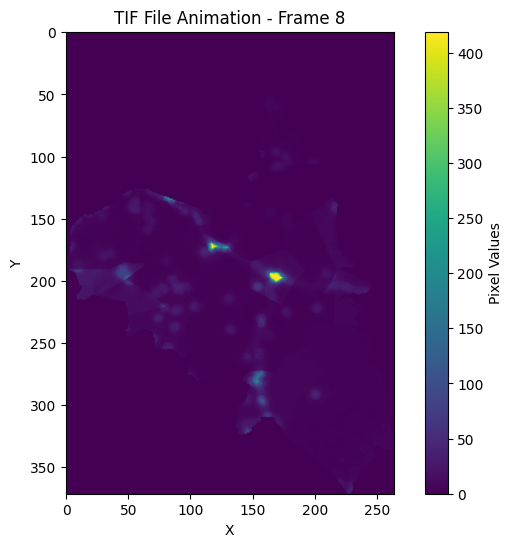

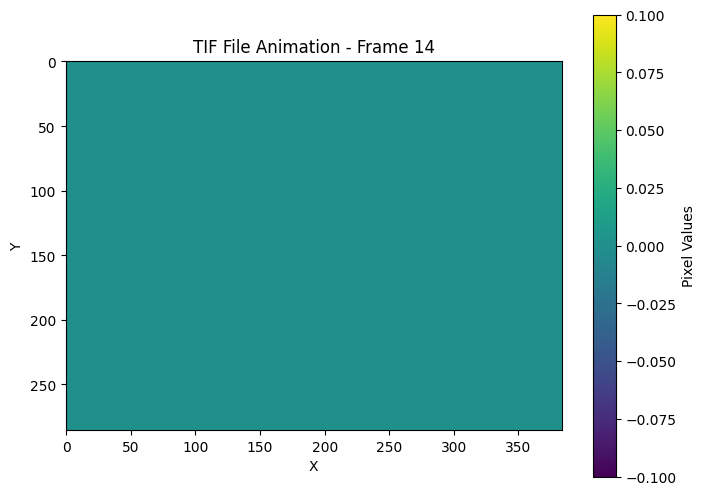

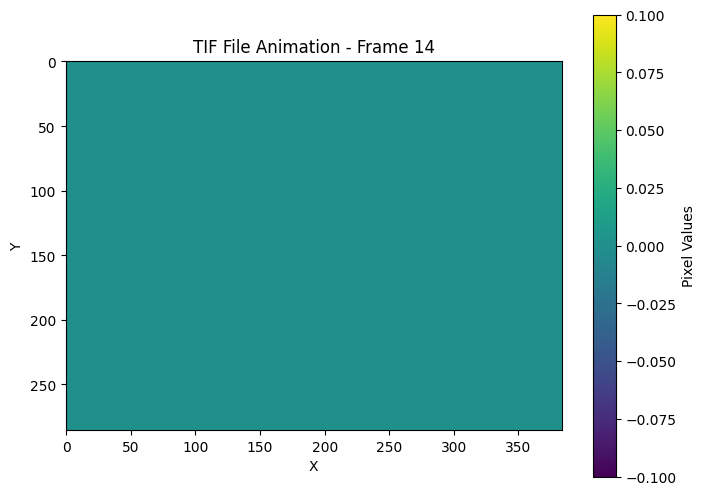

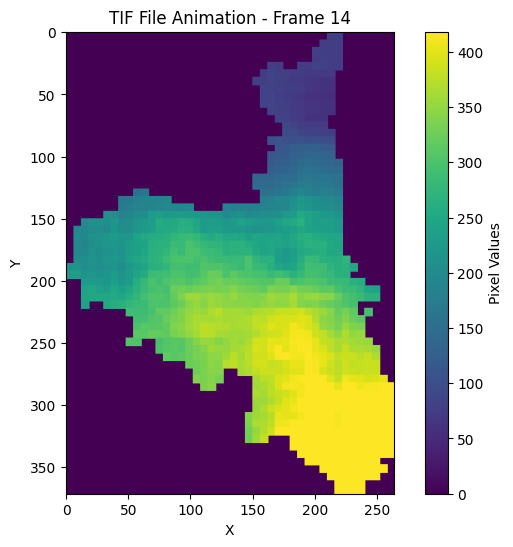

In [70]:
folders = os.listdir("Transformed")
for folder in folders:
    files = [os.path.join(f"Transformed/{folder}", p) for p in os.listdir(f"Transformed/{folder}")]
    print(files)

    def read_tif(file):
        ds = gdal.Open(file)
        band = ds.GetRasterBand(1)
        data = band.ReadAsArray()
        ds = None
        return data

    # Read the first file to get the dimensions
    sample_data = read_tif(files[0])

    # Create a figure and axis for the animation
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(sample_data, cmap='viridis', animated=True)
    plt.colorbar(img, ax=ax, label="Pixel Values")
    ax.set_title("TIF File Animation")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    def update(frame):
        data = read_tif(files[frame])
        img.set_array(data)
        ax.set_title(f"TIF File Animation - Frame {frame + 1}")
        return img,

    ani = FuncAnimation(
        fig, update, frames=len(files), interval=1000, blit=True
    )

    ani.save(f"{folder}.gif", writer="imagemagick")



MovieWriter imagemagick unavailable; using Pillow instead.


temp/Modis_Land_Cover_Data/2022LCT_norm.tif
temp/Modis_Land_Cover_Data/2022LCT_norm.tif
temp/Modis_Land_Cover_Data/2022LCT_norm.tif
temp/Modis_Land_Cover_Data/2022LCT_norm.tif
temp/Modis_Land_Cover_Data/2022LCT_norm.tif
temp/Modis_Land_Cover_Data/2020LCT_norm.tif
temp/Modis_Land_Cover_Data/2023LCT_norm.tif
temp/Modis_Land_Cover_Data/2013LCT_norm.tif
temp/Modis_Land_Cover_Data/2021LCT_norm.tif
temp/Modis_Land_Cover_Data/2010LCT_norm.tif
temp/Modis_Land_Cover_Data/2018LCT_norm.tif
temp/Modis_Land_Cover_Data/2011LCT_norm.tif
temp/Modis_Land_Cover_Data/2017LCT_norm.tif
temp/Modis_Land_Cover_Data/2019LCT_norm.tif
temp/Modis_Land_Cover_Data/2015LCT_norm.tif
temp/Modis_Land_Cover_Data/2016LCT_norm.tif
temp/Modis_Land_Cover_Data/2012LCT_norm.tif
temp/Modis_Land_Cover_Data/2014LCT_norm.tif


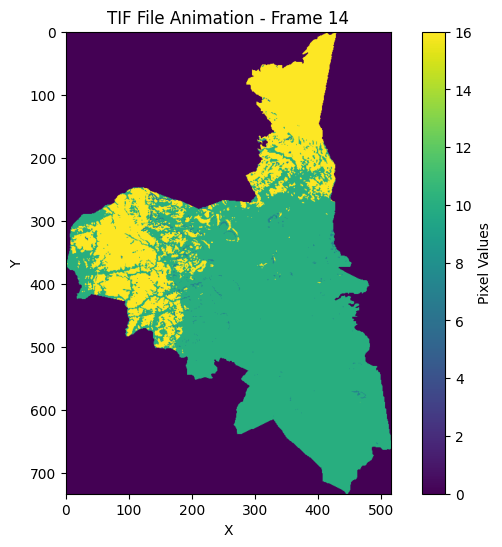

In [71]:
path = "temp/Modis_Land_Cover_Data"
files = [os.path.join(path, p) for p in os.listdir(path) if "norm" in p]

def read_tif(file):
    print(file)
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()
    ds = None
    return data

# Read the first file to get the dimensions
sample_data = read_tif(files[0])

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(sample_data, cmap='viridis', animated=True)
plt.colorbar(img, ax=ax, label="Pixel Values")
ax.set_title("TIF File Animation")
ax.set_xlabel("X")
ax.set_ylabel("Y")

def update(frame):
    data = read_tif(files[frame])
    img.set_array(data)
    ax.set_title(f"TIF File Animation - Frame {frame + 1}")
    return img,

ani = FuncAnimation(
    fig, update, frames=len(files), interval=1000, blit=True
)

ani.save(f"njksbgn.gif", writer="imagemagick")

In [73]:
from osgeo import ogr, osr, gdal

def rasterize_shapefile(shapefile_path, output_tif, target_extent, pixel_size, target_srs):
    """
    Rasterize a shapefile to a GeoTIFF that matches the normalized grid.
    
    Parameters:
      shapefile_path (str): Path to the .shp (shapefile) file.
      output_tif (str): Path to the output GeoTIFF.
      target_extent (tuple): (xmin, ymin, xmax, ymax) of the output grid.
      pixel_size (float): Target pixel resolution.
      target_srs (str): Target spatial reference as string, e.g. "EPSG:4326" or "EPSG:3857".
    """
    xmin, ymin, xmax, ymax = target_extent
    # Determine image dimensions from the target extent and pixel size.
    x_pixels = int((xmax - xmin) / pixel_size)
    y_pixels = int((ymax - ymin) / pixel_size)
    
    # Create the output GeoTIFF.
    driver = gdal.GetDriverByName('GTiff')
    target_ds = driver.Create(output_tif, x_pixels, y_pixels, 1, gdal.GDT_Byte)
    if target_ds is None:
        raise RuntimeError("Could not create output raster.")

    # Create geotransform.
    # Note: The geotransform is defined as:
    # (top left x, w-e pixel resolution, rotation (0 if north is up),
    #  top left y, rotation (0 if north is up), n-s pixel resolution (negative))
    geotransform = (xmin, pixel_size, 0, ymax, 0, -pixel_size)
    target_ds.SetGeoTransform(geotransform)
    
    # Set the projection.
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(target_srs.split(":")[1]))
    target_ds.SetProjection(srs.ExportToWkt())
    
    # Initialize the raster band.
    band = target_ds.GetRasterBand(1)
    band.Fill(0)  # Fill with 0 (nodata or background value)
    band.SetNoDataValue(0)
    
    # Open the vector shapefile.
    vector_ds = ogr.Open(shapefile_path)
    if vector_ds is None:
        raise RuntimeError("Could not open shapefile: " + shapefile_path)
    layer = vector_ds.GetLayer()
    
    # Rasterize: burn value 255 into the pixels where features exist.
    # You may also choose to burn an attribute value using the "ATTRIBUTE=fieldName" option.
    ret = gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[255])
    if ret != 0:
        raise RuntimeError("Rasterization failed with code " + str(ret))
    
    # Clean up
    target_ds = None
    vector_ds = None
    print(f"Rasterization complete. Output saved to {output_tif}")


# === Example Usage ===
# Replace these with your actual normalization parameters from your TIFF processing:
normalized_extent = (100000, 200000, 150000, 250000)  # (xmin, ymin, xmax, ymax) [example values]
normalized_pixel_size = 30  # e.g., 30 meters or as appropriate for your dataset
target_epsg = "EPSG:4326"  # or "EPSG:3857" depending on your normalized TIFFs

# Path to your shapefile (the .shp file is required; ancillary files will be picked up automatically)
shapefile_path = "Datasets_Hackathon/Streamwater_Line_Road_Network/Main_Road.shp"
output_rasterized_tif = "newly_shaped.tif"

rasterize_shapefile(shapefile_path, output_rasterized_tif, reference_extent, target_resolution, target_epsg)


Rasterization complete. Output saved to newly_shaped.tif


In [75]:
import re

In [ ]:
impor

In [96]:


def sort_files_by_year(files):
    print(files)
    def extract_year(file_name):
        print(file_name)
        # Use regex to find a 4-digit year in the file name
        match = re.search(r'\b(?:19|20)\d{2}\b', file_name)
        return int(match.group()) if match else float('inf')  # Default to infinity if no year is found
    return sorted(files, key=extract_year)

In [97]:
file_names = [
    "data_2023.tif",
    "data_2019.tif",
    "data_2025.tif",
    "data_2020.tif",
    "data_without_year.tif"
]

In [98]:
sorted_files = sort_files_by_year(file_names)


['data_2023.tif', 'data_2019.tif', 'data_2025.tif', 'data_2020.tif', 'data_without_year.tif']
data_2023.tif
data_2019.tif
data_2025.tif
data_2020.tif
data_without_year.tif


In [92]:
sorted_files

['data_2023.tif',
 'data_2019.tif',
 'data_2025.tif',
 'data_2020.tif',
 'data_without_year.tif']

In [88]:
import re

# Input string
text = "The event took place in 1999 and then again in 2023."

# Regex to extract years
years = re.findall(r'\b(?:19|20)\d{2}\b', text)
print(years)  # Output: ['1999', '2023']

['1999', '2023']


In [99]:
def extract_year(file_name):
    """
    Extracts a 4-digit year from the file name.
    If no year is found, returns infinity to sort such files last.
    """
    match = re.search(r'\b(19|20)\d{2}\b', file_name)
    return int(match.group()) if match else float('inf')  # Default to infinity if no year is found

def sort_files_by_year(files):
    """
    Sorts a list of file paths based on the year in their basenames.

    Parameters:
        files (list): List of file paths.

    Returns:
        list: Sorted list of file paths.
    """
    return sorted(files, key=lambda f: extract_year(os.path.basename(f)))

In [100]:
sort_files_by_year(file_names)

['data_2023.tif',
 'data_2019.tif',
 'data_2025.tif',
 'data_2020.tif',
 'data_without_year.tif']